<img src = "../../Data/bgsedsc_0.jpg">

# Project: Support Vector Machines (SVM)

## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Don't use features that you don't know the first day a patient enters the ICU, such as LOS.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test.csv*. Apply your final model to this extra dataset and submit to Kaggle competition to obtain accuracy of prediction (follow the requested format).

Try to optimize hyperparameters of your SVM model.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Test the performance on the test file by submitting to Kaggle, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

For the in-class version, feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for grading (In-class)
From more to less important:
+ SVMs method(s) have been used
+ Data preparation
+ Code runs
+ Probability of death for each test patient is computed
+ Accuracy of predictions for test patients is evaluated
+ Accuracy itself
+ Hyperparameter optimization
+ Class imbalance management


## Main criteria for grading (Extended)
From more to less important:
+ SVMs method(s) have been used
+ Data preparation
+ Probability of death for each test patient is computed
+ Accuracy of predictions for test patients is evaluated
+ Accuracy itself
+ Hyperparameter optimization
+ Class imbalance management
+ Neat and understandable code, with some titles and comments
+ Improved methods from what we discussed in class (properly explained/justified)
+ Code runs

## 1. Importing datasets

Note: Among other packages, in the following cell we import the helper functions provided in the course. Unfortunately, I had to change the name of it so that I could make use of it. Please, make sure to adapt it to your own computer. 

In [172]:
%matplotlib inline
import matplotlib.pylab as plt

import os,sys,inspect
currentdir = os.getcwd()
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from BSE_CML1_utils.helper_functions import *

import pandas as pd
import numpy as np
import sklearn

np.random.seed(3123) # impose random seed for reproducibility

In [173]:
# Training dataset
X_train=pd.read_csv('../../Data/mimic_train.csv')
Y_train = X_train[["icustay_id","HOSPITAL_EXPIRE_FLAG"]]
print(X_train.shape)

(20885, 44)


In [174]:
# Test dataset (to produce predictions)
X_test=pd.read_csv('../../Data/mimic_test_death.csv')
print(X_test.shape)

(5221, 39)


In [175]:
comorbidities = pd.read_csv('../../Data/extra_data/MIMIC_diagnoses.csv')
print(comorbidities.shape)

(651047, 4)


In [176]:
# Sample output prediction file (waiting to be filled by the predictions)
pred_sample=pd.read_csv('../../Data/mimic_kaggle_death_sample_submission.csv')
print(pred_sample.HOSPITAL_EXPIRE_FLAG.value_counts())

0    5221
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64


## 2. Preprocessing and Feature engineering 

### 2.1 Basic preprocessing

In the following two cells we remove those columns that are not common in both X_train and X_test, and we also remove features that seem irrelevant (heuristic step). Lastly, we look at the column types and how many Nulls they are populated with. 

In [177]:
#Get rid of columns not shared by X_train and X_test
not_shared_columns = (X_train.columns).isin(X_test.columns)
print("Unshared columns to delete:",X_train.columns[~not_shared_columns])
X_train = X_train.loc[:,not_shared_columns]

#And also get rid of variables that seem irrelevant or difficult to handle at a first glance
X_train = X_train.drop(axis = 1, labels = ['RELIGION','MARITAL_STATUS','ETHNICITY','DIAGNOSIS','FIRST_CAREUNIT'])
X_test= X_test.drop(axis = 1, labels = ['RELIGION','MARITAL_STATUS','ETHNICITY','DIAGNOSIS','FIRST_CAREUNIT'])
#Notice how DIAGNOSIS has been removed due to the large amount of possible values and the lack of consistency in reporting
#We will rather use the code of the main Diagnosis, represented in the ICD9_diagnosis variable and the comorbidities in extra_data 

print("Current X_train columns:", X_train.columns)

Unshared columns to delete: Index(['HOSPITAL_EXPIRE_FLAG', 'DOD', 'DISCHTIME', 'DEATHTIME', 'LOS'], dtype='object')
Current X_train columns: Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB',
       'ADMITTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'ICD9_diagnosis'],
      dtype='object')


In [178]:
#Check types and missing data

#Number of nans per column
Nulls_train=X_train.isnull().sum()
Nulls_test=X_test.isnull().sum()

#Names of the columns with nan values
Nulls_train_col = Nulls_train[Nulls_train>0].index
Nulls_test_col = Nulls_test[Nulls_test>0].index

#The following dataframes show the type of data in each column alongside their number of nans
pd.DataFrame({'Number of nan':Nulls_train, 'column type': X_train.dtypes})
pd.DataFrame({'Number of nan':Nulls_test, 'column type': X_test.dtypes})
#We can see that the first 3 variables are reported as numerical when they are not.

,Number of nan,column type
subject_id,0,int64
hadm_id,0,int64
icustay_id,0,int64
HeartRate_Min,545,float64
HeartRate_Max,545,float64
HeartRate_Mean,545,float64
SysBP_Min,551,float64
SysBP_Max,551,float64
SysBP_Mean,551,float64
DiasBP_Min,552,float64


In [179]:
#Make the 3 first columns a str type feature
X_train = X_train.astype({'icustay_id': 'string','subject_id': 'string', 'hadm_id': 'string'})
X_test = X_test.astype({'icustay_id': 'string','subject_id': 'string', 'hadm_id': 'string'})

### 2.2 Dates handling and addition of 'Age' feature.

Note: Mimic III dataset shifts dates and preserves age for all patients except for +89 years old patiens. For those, the age isn't preserved, and instead it's reported as 300yo. We deal with this in the following cell 

In [180]:
#Handle dates and compute age:
import datetime as dt

#For train dataset
X_train['Diff'] = pd.to_timedelta(X_train['Diff'], unit='days')
X_train['ADMITTIME'] = pd.to_datetime(X_train['ADMITTIME'], format='%Y-%m-%d %H:%M:%S',errors = 'coerce') 
X_train['DOB'] = pd.to_datetime(X_train['DOB'], format='%Y-%m-%d %H:%M:%S', errors = 'coerce')

X_train['ADMITTIME'] = (X_train['ADMITTIME'] + X_train['Diff']).dt.date #dt.date to keep only the date, not the time
X_train['DOB'] = (X_train['DOB'] + X_train['Diff']).dt.date 
X_train['Age'] =  (X_train['ADMITTIME'] - X_train['DOB'])
X_train['Age'] = [item.days/365 if item.days<32850 else 90 for item in X_train['Age']] #Make 'Age' in years. Additionally, if age>90 yars, return 90 = 32850 days 
X_train.drop(axis = 1, labels = ['DOB','Diff'], inplace=True) #Drop unnecessary columns

#Same for Test dataset
X_test['Diff'] = pd.to_timedelta(X_test['Diff'], unit='days')
X_test['ADMITTIME'] = pd.to_datetime(X_test['ADMITTIME'], format='%Y-%m-%d %H:%M:%S',errors = 'coerce') 
X_test['DOB'] = pd.to_datetime(X_test['DOB'], format='%Y-%m-%d %H:%M:%S', errors = 'coerce')

X_test['ADMITTIME'] = (X_test['ADMITTIME'] + X_test['Diff']).dt.date #dt.date to keep only the date, not the time
X_test['DOB'] = (X_test['DOB'] + X_test['Diff']).dt.date
X_test['Age'] =  (X_test['ADMITTIME'] - X_test['DOB'])
X_test['Age'] = [item.days/365 if item.days<32850 else 90 for item in X_test['Age']] #Make 'Age' in years. Additionally, if age>90 yars, return 90 = 32850 days 
X_test.drop(axis = 1, labels = ['DOB','Diff'], inplace=True)

### 2.3 Add the number of times a patient has been addmitted at the ICU.

The addition of this feature comes purely from intuition. With this, we hope to account for the possibility that there exists a correlation between the number of times a patient has been addmitted at the icu, and chances of surviving.

Note: In the folowing code we make use of both the train and test data together. This is because we assume the
hospital can always check the amount of times a patient has been admitted to icu in the past (at least since 
the creation of the dataset).

In [181]:
#Count the number of times a subject had been addmitted at the ICU before each stay. 
vertical_stack = pd.concat([X_train, X_test], axis=0)
vertical_stack.sort_values(['subject_id','ADMITTIME'], inplace=True)
vertical_stack['icu_count'] = vertical_stack.groupby('subject_id')['subject_id'].cumcount()

#Add the new column to X_train and X_test
X_train['icu_count'] = X_train['icustay_id'].map(vertical_stack.set_index('icustay_id')['icu_count'])
X_test['icu_count'] = X_test['icustay_id'].map(vertical_stack.set_index('icustay_id')['icu_count'])

### 2.4 Managing the Diagnosis features.

We now adress how we will deal with the diagnosis variable. Since we are dealing with a categorical variable with high cardinality, dummifying the variable doesn't seem to be a good strategy as we will increase too much the dimensionality of the dataset, with all the problems that it entails. We then turn to Target Encoding. The idea behind target ecnoding is to substitute each label (diagnostic) with the mean of the corresponding target for that label (the percentage of death we have registered). Target encoding is good because it picks up values that can explain the target, however, it has an important enemy: over-fitting. Indeed, relying on an average value isn’t always a good idea when the number of values used in the average is low. You’ve got to keep in mind that the dataset you’re training on is a sample of a larger set. This means that whatever artifacts you may find in the training set might not hold true when applied to another dataset (i.e. the test set). We aim to reduce the over-fitting by means of additive smoothing.

Imagine we only have registered two subjects with a specific diagnostic, and both got cured. The point is that the average can’t be trusted because there are too few values. The trick is to “smooth” the average by including the total death rate over all diagnostics. In other words, if there aren’t many ratings we should rely on the global average rating, whereas if there enough ratings then we can safely rely on the local average.

Mathematically, this is equivalent to:

$$x_i = \frac{(n*\mu_i + m*\mu)}{n+m}$$

Where $\mu_i$ is the average deathliness of a specific diagnostic, $\mu$ is the deadliness over all diagnostics, n is the number of subjects diagnosed with with "$i$" and $m$ is the smoothing parameter.

In this notation, $m$  is the only parameter you have to set. The idea is that the higher it is, the more you’re going to rely on the overall mean. If  is equal to 0 then you’re simply going to compute the empirical mean.

This is by no means a perfect metric, it suffers from several problems such as the fact that we have to decide what's a good amount of "smoothing" or the fact that we are calculating the deadliness of a diagnostic without considering other risk factors such as the age or the comorbidities.

In [148]:
X_train = pd.concat([X_train, Y_train['HOSPITAL_EXPIRE_FLAG']], axis = 1)

def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count','sum','mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)
    agg['smooth'] = smooth
    # Replace each value by the according smoothed mean
    return df[by].map(smooth), agg

smooth_mean = calc_smooth_mean(X_train,'ICD9_diagnosis', 'HOSPITAL_EXPIRE_FLAG', m=5)

In [149]:
#Table of deadliness per ICD9 diagnosis

ICD9_deadliness = smooth_mean[1]
ICD9_deadliness['ICD9_CODE'] = ICD9_deadliness.index.astype('str')
ICD9_deadliness.sort_values(axis=0,by='sum',ascending=False).head()
ICD9_deadliness.rename(columns = {'smooth' : 'smooth_main'},inplace=True)
ICD9_deadliness.head() 
#Notice that 'count' is the number of diagnosis we have for that specific desease, 
#'sum' is the number of people who died from it,
#'mean' is the deadliness rate we have registered, and
#'smooth' is the smoothened mean accounting for the amount of patients we have registered

,count,sum,mean,smooth_main,ICD9_CODE
ICD9_diagnosis,,,,,
0031,2,0,0.000000,0.080201,0031
0041,1,0,0.000000,0.093568,0041
0059,1,0,0.000000,0.093568,0059
00845,76,8,0.105263,0.105696,00845
0085,1,0,0.000000,0.093568,0085


In [150]:
#Add the smooth deadliness of the main diagnosis in both Train and Test datasets.
X_train.rename(columns = {'ICD9_diagnosis' : 'ICD9_CODE'}, inplace = True) 
X_train = X_train.merge(ICD9_deadliness[['ICD9_CODE','smooth_main']],how='left',on='ICD9_CODE')

X_test.rename(columns = {'ICD9_diagnosis' : 'ICD9_CODE'}, inplace = True) 
X_test= X_test.merge(ICD9_deadliness[['ICD9_CODE','smooth_main']],how='left',on='ICD9_CODE')
#Notice how some of the subjects in X_test will report smooth_main=NaN as we don't have any data on the deadliness of that diagnosis in our X_train 
X_test['smooth_main'] = X_test['smooth_main'].fillna(0)
X_train.head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,Glucose_Mean,GENDER,ADMITTIME,ADMISSION_TYPE,INSURANCE,ICD9_CODE,Age,icu_count,HOSPITAL_EXPIRE_FLAG,smooth_main
0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,...,160.777778,F,2008-06-15,EMERGENCY,Medicare,5789,69.608219,0,0,0.097807
1,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,...,103.000000,F,2010-12-27,EMERGENCY,Private,53013,42.104110,0,0,0.093568
2,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,...,217.636364,F,2010-11-10,EMERGENCY,Medicare,56983,68.210959,0,0,0.178070
3,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,...,125.000000,F,2011-09-26,ELECTIVE,Medicare,5533,74.961644,0,0,0.031189
4,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,113.000000,F,2008-09-12,EMERGENCY,Medicare,56211,79.424658,1,0,0.028915


### 2.5 Comorbidities

Additionally to the main diagnosis, we try to account for the additional Comorbitities the patient suffers from by creating a pseudo-index that we call "smooth" that will be increase with the amount of comorbidities reported and the severity of those.

This pseudo-index will essentially add up the smoothened dealiness rate for each comorbitity. Note that this is an extreamly naive approach and does not take into consideration the true relationship between the diagnosis, and even worse, the dealiness rates of the main diagnosis were calculated in the first place without accounting for the comorbidities of each patient.

In [151]:
#Add smooth next to each comorbidity  
comorbidities_deadliness=comorbidities.merge(ICD9_deadliness[['ICD9_CODE','smooth_main']],how='left',on='ICD9_CODE')
comorbidities_deadliness['smooth'] = comorbidities_deadliness['smooth_main'].fillna(0)
comorbidities_deadliness.drop(columns=['SEQ_NUM','SUBJECT_ID', 'smooth_main'],inplace=True)
comorbidities_deadliness.head()

,HADM_ID,ICD9_CODE,smooth
0,108811,53240,0.096580
1,108811,41071,0.062385
2,108811,53560,0.093568
3,108811,40390,0.035088
4,108811,5859,0.000000


In [152]:
#Aggregate based on hadm_id: Summing up the smooth by hadm_id
hadm_deadliness= comorbidities_deadliness.groupby(['HADM_ID']).sum()
hadm_deadliness['hadm_id'] = hadm_deadliness.index.astype('str') #Make it string to match X_train format
hadm_deadliness.reset_index(inplace=True)
hadm_deadliness.drop(columns=['HADM_ID'],inplace=True)
hadm_deadliness.head()

,smooth,hadm_id
0,0.583069,100001
1,0.779679,100003
2,1.193306,100006
3,0.779984,100007
4,0.189500,100009


In [154]:
#Add hadm's smooth to X_train and X_test
X_train=X_train.merge(hadm_deadliness[['hadm_id','smooth']],how='left',on='hadm_id')
X_test=X_test.merge(hadm_deadliness[['hadm_id','smooth']],how='left',on='hadm_id')

#Drop unecessary columns:
Y_train = X_train[["icustay_id","HOSPITAL_EXPIRE_FLAG"]]
X_train= X_train.drop(axis = 1, labels = ['ADMITTIME', 'subject_id', 'hadm_id', 'ICD9_CODE','HOSPITAL_EXPIRE_FLAG'])
X_test= X_test.drop(axis = 1, labels = ['ADMITTIME', 'subject_id', 'hadm_id', 'ICD9_CODE'])

#These are the datasets containing all the features we will use for our Classification model 
X_test.head()

,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,...,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,ADMISSION_TYPE,INSURANCE,Age,icu_count,smooth_main,smooth
0,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,77.0,52.018182,...,89.0,230.0,134.684211,M,ELECTIVE,Medicare,81.605479,0,0.017739,0.674898
1,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,86.0,65.578947,...,152.0,1016.0,391.526316,M,EMERGENCY,Private,48.416438,0,0.009025,0.890278
2,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,76.0,66.703704,...,100.0,149.0,123.000000,M,ELECTIVE,Medicare,42.210959,1,0.043185,1.054183
3,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,99.0,62.854545,...,130.0,177.0,147.250000,F,EMERGENCY,Private,84.356164,0,0.320176,1.106400
4,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,133.0,72.833333,...,74.0,248.0,155.500000,F,EMERGENCY,Medicare,53.030137,1,0.153278,1.175780


### 2.6 Column transformers to deal with heterogenous columns

We finish the preprocessing by managing the binary and the numerical columns. In essence, we build a column transformer object that will deal separately with the numerical and the categorical features, performing SimpleImputer() and OneHotEncoder(), respectively.

In [155]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline

#Preprocesor
numeric_features = X_train.select_dtypes(include=[np.number]).columns #Names of the numerical variables except HOSPITAL_EXPIRE_FLAG
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))])
#   ('scaler', StandardScaler(with_mean=False))])

categorical_features = ['GENDER','ADMISSION_TYPE','INSURANCE'] #ICD9_diagnosis feature not included not included since it deserves a specific treatement
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop= 'first', handle_unknown='error'))])

transformers = [
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
]

preprocessor = ColumnTransformer(
    transformers,
    remainder='passthrough')

In [156]:
#Helper functions to preserve column names after column transforms

from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin
from category_encoders import TargetEncoder
from category_encoders.glmm import GLMMEncoder

def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator, _VectorizerMixin):
            # handling all vectorizers
            return [f'vec_{f}' \
                for f in estimator.get_feature_names()]
        elif isinstance(estimator, TargetEncoder):
            return estimator.get_feature_names()
        elif isinstance(estimator, GLMMEncoder):
            return estimator.get_feature_names()
        else:
            return estimator.get_feature_names(feature_in)
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in


def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct._feature_names_in[features])
                
    return output_features

In [157]:
transformed_data = preprocessor.fit_transform(X_train, Y_train['HOSPITAL_EXPIRE_FLAG'])
X_train = pd.DataFrame(transformed_data
             ,columns=get_ct_feature_names(preprocessor))

transformed_data_test = preprocessor.transform(X_test)
X_test = pd.DataFrame(transformed_data_test
             ,columns=get_ct_feature_names(preprocessor))

X_train.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,smooth_main,smooth,GENDER_M,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,icustay_id
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,...,0.097807,1.199037,0.0,1.0,0.0,0.0,1.0,0.0,0.0,228357
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,...,0.093568,0.109608,0.0,1.0,0.0,0.0,0.0,1.0,0.0,221004
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,...,0.17807,1.150739,0.0,1.0,0.0,0.0,1.0,0.0,0.0,296315
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,...,0.031189,0.685405,0.0,0.0,0.0,0.0,1.0,0.0,0.0,245557
4,69.705904,105.239801,85.18025,91.110564,150.72592,119.145423,44.327854,88.360784,62.511614,56.293064,...,0.028915,1.3851,0.0,1.0,0.0,0.0,1.0,0.0,0.0,225281


### 2.7 Check for Class Imbalance

The following cell is simply to manifest the fact that we are dealing with Class Imbalance and we will have to take care of it somehow.

0    18540
1     2345
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64


(20885, 2)

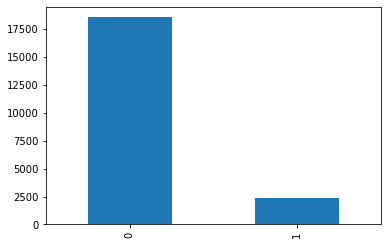

In [158]:
#Class imbalance?
print(Y_train['HOSPITAL_EXPIRE_FLAG'].value_counts())
Y_train['HOSPITAL_EXPIRE_FLAG'].value_counts().plot(kind="bar")
Y_train.shape

## 3. Building and Fitting the model

We have build a pipeline for our model in order to make things easier when it comes to the sampling and scaling of the data. This is because it makes it easier to try several methods in an organized and effective way. Additinally, it also has the advantage that it allows us to tune hyperparameter that are not strictly from the core ML model, but the ones that belong to the prior processing of the data. 

Our final model is made out of 3 stages:
- Dealing with the class Imbalance issue by means of random under sampling.
- Scaling all the features so that they have 0 mean and variance 1.
- SVM with a polygon kernel.

Notice that the parameters and methods of the final model across stages have been found by perofrming several GridsSarchCV on different permutations.

In [159]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler

scaler = StandardScaler()
svc = SVC(probability = True)
samplr = RandomUnderSampler()
pipeline = Pipeline([('samplr',samplr),('scaler',scaler),('svc',svc)])

In [160]:
# Simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [164]:
from sklearn.model_selection import GridSearchCV

grid_params = {'svc__kernel' : ['poly'], 'svc__degree' : [3], 'svc__C' : [0.4,0.5,0.6]}
grid = GridSearchCV(pipeline, param_grid = grid_params, cv = 10, scoring = 'roc_auc',  verbose=10, n_jobs = -1)

In [165]:
grid.fit(X_train.drop(axis=1,labels=['icustay_id']),Y_train['HOSPITAL_EXPIRE_FLAG'])

Fitting 10 folds for each of 3 candidates, totalling 30 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('samplr', RandomUnderSampler()),
                                       ('scaler', StandardScaler()),
                                       ('svc', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.4, 0.5, 0.6], 'svc__degree': [3],
                         'svc__kernel': ['poly']},
             scoring='roc_auc', verbose=10)

In [166]:
#Best performing estimator
clf_performance(grid,'SVC')

SVC
Best Score: 0.8853199728576715
Best Parameters: {'svc__C': 0.5, 'svc__degree': 3, 'svc__kernel': 'poly'}


In [167]:
# Predicting using the best estimator.
y_hat_clf_svc = grid.best_estimator_.predict_proba(X_test.drop(axis=1,labels=['icustay_id']))

Note that since we have performed under-sampling, these are not proper estimates of the class probability: we need to correct for the biased sample by rescaling the predicted probability

In [168]:
## the correction factor: 
q1 = Y_train['HOSPITAL_EXPIRE_FLAG'].sum()/len(Y_train['HOSPITAL_EXPIRE_FLAG'])
r1 = 0.5

def reweight(pi,q1=0.5,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

y_pred_ros_proba = pd.DataFrame(y_hat_clf_svc[:,1]).apply(reweight,args=(q1,r1))

In [169]:
y_final = pd.DataFrame({'icustay_id': X_test['icustay_id'], 'HOSPITAL_EXPIRE_FLAG': y_pred_ros_proba[0]})
y_final.head()

,icustay_id,HOSPITAL_EXPIRE_FLAG
0,208169,0.008331
1,251754,0.009308
2,242171,0.007829
3,263035,0.154501
4,279388,0.076147


In [170]:
#Adding the final predictions into the dataframe we will submit to Kaggle
pred_sample = pred_sample.astype({'icustay_id': 'string'})
y_final = y_final.astype({'icustay_id': 'string'})

pred_sample=pred_sample.set_index('icustay_id')
pred_sample.update(y_final.set_index('icustay_id'))
pred_sample.reset_index(inplace=True)
pred_sample.sort_values('icustay_id').head()

,icustay_id,HOSPITAL_EXPIRE_FLAG
1937,200011,0.007825
4908,200044,0.062550
829,200049,0.527398
4378,200063,0.138889
4946,200081,0.103826


In [47]:
pred_sample.to_csv('mimic_kaggle_death_sample_submission.csv', index=False)